In this file we 
- create true data for with and no planet 
- fit the no planet data using the matrix method 
- fit the planet data using least squares 

In [7]:
# importing packages, functions, etc 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from numpy import cos, sin
from scipy.linalg import lstsq
from scipy.optimize import leastsq
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100

from functions_new_parameters import cov_func
from functions_new_parameters import generate_parallax_signal
from functions_new_parameters import signal_func_np
from functions_new_parameters import signal_func
from functions_new_parameters import normalized_residuals
from functions_new_parameters import calculate_a_hat
from functions_new_parameters import find_chi_squared


rad_mas = 206264806

wp_params = ['Delta alpha 0', 'Delta delta 0', 'mu_alpha', 'mu_delta', 'parallax', 'sqrt[cos(i)]cos(Omega)', 'sqrt[cos(i)]sin(Omega)', 'sqrt[e]cos(omega)', 'sqrt[e]sin(omega)' ,'m_planet', 'P_orb', 't_peri']
np_params = ['Delta alpha 0', 'Delta delta 0', 'mu alpha', 'mu delta', 'parallax']

In [8]:
# initial inputs 
np.random.seed(5) 

N = 100 # number of timesteps 
S = 50  # number of samples 

times = np.linspace(0, 4.2, N)
theta = np.linspace(0, 2*np.pi, N)

alpha0, delta0 = 1, 0.3

np_truepars = np.array((0,                      # alpha                                     [rad]
                        0,                      # delta                                     [rad]
                        2.3084641853871365e-07, # proper motion in RA direction  (mu alpha) [rad/year]
                        1.770935480191023e-07,  # proper motion in Dec direction (mu delta) [rad/year]
                        9.699321049402031e-08)) # parallax                                  [rad]                 # time of pericentre passage                [years]

wp_truepars = np.array((0,                      # alpha                                     [rad]
                        0,                      # delta                                     [rad]
                        2.3084641853871365e-07, # proper motion in RA direction  (mu alpha) [rad/year]
                        1.770935480191023e-07,  # proper motion in Dec direction (mu delta) [rad/year]
                        9.699321049402031e-08,  # parallax                                  [rad]
                        0.5348901624946122,     # var1: sqrt(cosi)cos(Omega)                [unitless]
                        0.8330420709110249,     # var2: sqrt(cosi)sin(Omega)                [unitless]
                        -0.18610652302818084,   # var3: sqrt(e)cos(omega)                   [unitless]
                        0.406650171629573,      # var4: sqrt(e)sin(omega)                   [unitless]
                        0.0143188,              # mass of planet                            [solar masses]
                        0.46146592515998475 ,   # orbital period                            [years]
                        0.0))                   # time of pericentre passage                [years]

sigma_err = (1e-5*np.pi/180/60/60)*10       # [rad]

# No planet: Matrix method 

In [9]:
# creating true and observed signals

_ , _ , np_eta_true = signal_func_np(np_truepars, alpha0, delta0, times, theta)

np_eta_obs = np_eta_true + np.random.normal(0, sigma_err, N) 

In [10]:
# creating matrix 

PI_ra, PI_dec = generate_parallax_signal(alpha0, delta0, 1, times)

M = np.zeros((N, 5))

for i in range(N):
    M[i,0] = cos(theta[i])
    M[i,1] = sin(theta[i])
    M[i,2] = cos(theta[i]) * times[i]
    M[i,3] = sin(theta[i]) * times[i]
    M[i,4] = cos(theta[i])*PI_ra[i] + sin(theta[i])*PI_dec[i]
        
np_cov = cov_func(M, sigma_err, print_cov=False)

np_best_fit_val,  _,  _,  _  = lstsq(M, np_eta_obs)

_ , _, np_eta_best = signal_func_np(np_best_fit_val, alpha0, delta0, times, theta)

In [11]:
array = np.zeros((N, 5))

x = np_best_fit_val

for i in range(N):
    for j in range(5):
        array[i,j] = M[i,j]*x[j]
    
array_row_sums = np.sum(array, axis=1)   
np_chi_sq = np.sum((array_row_sums - np_eta_true)**2/sigma_err**2)
print(np_chi_sq)  

0.8821884976404004


# With planet: $\texttt{leastsq}$

In [13]:
# creating true and observed data 
_, _, wp_eta_true = signal_func(wp_truepars, alpha0, delta0, times, theta) 

wp_eta_obs = np_eta_true  +  np.random.normal(0, sigma_err, N) 

In [14]:
# using leastsq to fit 
guess = wp_truepars * (1 + np.random.uniform(0,0.0001))

wp_best_fit_val, wp_cov, _ , _ , _ = leastsq(normalized_residuals, guess, args=(alpha0, delta0, sigma_err, wp_eta_obs, times, theta), full_output=1)

# _,_, wp_eta_best = signal_func(wp_best_fit_val, alpha0, delta0, times, theta)

/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_new_parameters.py:36: RuntimeWarning: invalid value encountered in sqrt
  sin_i = np.sqrt(1-cos_i**2)
/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_new_parameters.py:94: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt((1-e**2))*sin(E)


In [15]:
# print(wp_cov)

# Figure 5 

### Setting true values of parameters for the samples

In [16]:
# setting the true parameters with no planet 

np_truepars_array = np.zeros((S, 5))

np_truepars_array[:,0] = np.random.normal(0, 1.93925472e-10, S)    # Delta_alpha_0
np_truepars_array[:,1] = np.random.normal(0, 1.93925472e-10, S)    # Delta_delta_0
np_truepars_array[:,2] = np_truepars[2]                            # mu_alpha
np_truepars_array[:,3] = np_truepars[3]                            # mu_delta
np_truepars_array[:,4] = np_truepars[4]                            # varpi

In [17]:
# setting extra parameters needed to find true parameters for with planet 

extra_params = np.zeros((S, 4))

extra_params[:,0] = np.random.uniform(0, 0.5, S)      # e
extra_params[:,1] = np.random.uniform(0, 2*np.pi, S)  # omega
extra_params[:,2] = np.random.uniform(0, 2*np.pi, S)  # Omega
extra_params[:,3] = np.random.uniform(0, 1, S)        # cos i 

In [18]:
# setting true parameters for with planet 

wp_truepars_array = np.ones((S, 12))

wp_truepars_array[:,0] = np.random.normal(0, 1.93925472e-10, S)            # Delta_alpha_0
wp_truepars_array[:,1] = np.random.normal(0, 1.93925472e-10, S)            # Delta_delta_0
wp_truepars_array[:,2]  = wp_truepars[2]                                   # mu_alpha
wp_truepars_array[:,3]  = wp_truepars[3]                                   # mu_delta 
wp_truepars_array[:,4]  = wp_truepars[4]                                   # varpi 
wp_truepars_array[:,9]  = wp_truepars[9]                                   # m_planet 
wp_truepars_array[:,10] = wp_truepars[10]                                  # P_orb 
wp_truepars_array[:,11] = np.random.uniform(0, wp_truepars_array[:,10], S) # t_peri

for i in range(S):
    wp_truepars_array[i,5], wp_truepars_array[i,6], wp_truepars_array[i,7], wp_truepars_array[i,8] = find_var_from_param(extra_params[i,0], extra_params[i,1], extra_params[i,2], extra_params[i,3]) # var1, var2, var3, var4

### Creating data where $\sigma$ changes 

#### Creating arrays to fill

In [24]:
wp_eta_true_array = np.zeros((S, N))

wp_eta_obs_array = np.zeros((S, N))

wp_best_fit_val_array = np.zeros((S, 12))

noise = np.zeros((S,N))

guess_array = np.zeros((S,12))

wp_eta_best_array = np.zeros((S, N))
best_eta_np_array = np.zeros((S, N))


SN = np.zeros((S))

wp_chi_sq_array = np.zeros((S))
chi_squared_np_array = np.zeros((S))

Delta_BIC = np.zeros((S))

#### Setting $\hat{a}$

In [25]:
a_hat = calculate_a_hat(wp_truepars[4], wp_truepars[9], wp_truepars[10])

#### Setting $\sigma$

Text(0.5, 0, '$\\sigma$')

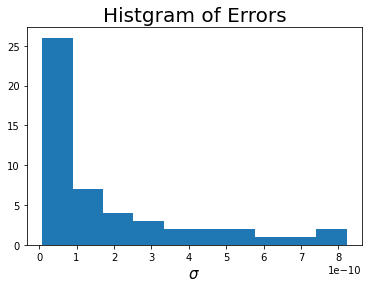

In [26]:
sigma_err_array = np.geomspace(0.01, 1, S)*a_hat

plt.hist(sigma_err_array)
plt.title('Histgram of Errors', fontsize = 20)
plt.xlabel('$\sigma$', fontsize = 15)

#### Using for loop to fill arrays and make sigmal

In [28]:
for i in range(S):
    # finding true signal with and without planet 
    _, _ , wp_eta_true_array[i] = signal_func(wp_truepars_array[i], alpha0, delta0, times, theta) 
    
    # creating noise to turn true data into observed data
    noise[i] = np.random.normal(0, sigma_err_array[i], N)
    
    # observed data is true data plus some noise 
    wp_eta_obs_array[i] = wp_eta_true_array[i] + noise[i]
    
    # guess
    guess_array[i] = wp_truepars_array[i] #* (1 + np.random.uniform(0,0.0001))
    
    # getting best/fitted values 
    wp_best_fit_val_array[i], _, _, _, _ = leastsq(normalized_residuals, guess_array[i], args=(alpha0, delta0, sigma_err_array[i], wp_eta_obs_array[i], times, theta), full_output=1)

    # creating best signal from the best fit 
    _, _, wp_eta_best_array[i] = signal_func(wp_best_fit_val_array[i], alpha0, delta0, times, theta)
    
    # finding S/N for each sample
    SN[i] = a_hat/sigma_err_array[i]
    
    # finding chi squared for with and without planet
    wp_chi_sq_array[i] = find_chi_squared(wp_eta_best_array[i], wp_eta_true_array[i])

### Calculating $BIC$ and $\Delta BIC$

In [38]:
np_BIC = np_chi_sq + 5 * np.log(N)

wp_BIC = wp_chi_sq_array + 12*np.log(N)

Delta_BIC = wp_BIC - np_BIC
Delta_BIC

array([31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028,
       31.3540028, 31.3540028, 31.3540028, 31.3540028, 31.3540028])